# <font size="7">Libs</font>

In [1]:
import torch

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
print('torch version (<2): ', torch.__version__)
# !pip install pytorch-lifestream
import ptls
from ptls.frames import PtlsDataModule
from ptls.frames.coles import losses, sampling_strategies
from ptls.frames.coles import split_strategy
from ptls.frames.inference_module import InferenceModule

from ptls.nn.seq_encoder import agg_feature_seq_encoder
from ptls.nn import RnnSeqEncoder, TrxEncoder, Head
from ptls.nn.seq_encoder.agg_feature_seq_encoder import AggFeatureSeqEncoder

from ptls.data_load.datasets import AugmentationDataset, MemoryMapDataset
from ptls.data_load.augmentations import AllTimeShuffle, DropoutTrx
from ptls.data_load.datasets.parquet_dataset import ParquetDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.data_load.datasets import parquet_file_scan
from ptls.data_load.datasets import ParquetDataset, ParquetFiles, AugmentationDataset
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.data_load.augmentations import DropoutTrx
from ptls.data_load.datasets import inference_data_loader
from ptls.data_load.utils import collate_feature_dict

from functools import partial

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

torch version (<2):  1.12.1+cu102


In [2]:
import transformers
transformers.__version__

'4.34.1'

In [3]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

<Figure size 800x600 with 0 Axes>

# <font size="7">Data Module</font>

In [4]:
data_module = PtlsDataModule(
    train_data=ptls.frames.coles.ColesDataset(
        splitter=split_strategy.SampleSlices(split_count=5, cnt_min=25, cnt_max=200),
        data=ptls.data_load.datasets.AugmentationDataset(
            data=MemoryMapDataset(
                data=ParquetDataset(
                    i_filters=[SeqLenFilter(min_seq_len=25)],
                    data_files=parquet_file_scan(file_path='src/ptls-experiments/scenario_age_pred/data/train_trx_file.parquet',
                                                 valid_rate=0.05,
                                                 return_part='train')
                )
            
            ),
            f_augmentations=[ptls.data_load.augmentations.DropoutTrx(trx_dropout=0.01)]
        )
    ),
    train_batch_size=64,
    train_num_workers=16,
)

# <font size="7">Model</font>

# <font size="6">Loss Block</font>

In [5]:
import torch
from torch import nn as nn
from torch.nn import functional as F

class L2NormEncoder(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, x: torch.Tensor):
        return x / (x.pow(2).sum(dim=-1, keepdim=True) + self.eps).pow(0.5)

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss

    "Signature verification using a siamese time delay neural network", NIPS 1993
    https://papers.nips.cc/paper/769-signature-verification-using-a-siamese-time-delay-neural-network.pdf
    """

    def __init__(self, margin, sampling_strategy):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = sampling_strategy
        
        self.norm = L2NormEncoder()

    def forward(self, embeddings, target):
        embeddings = self.norm(embeddings)

        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        positive_loss = F.pairwise_distance(embeddings[positive_pairs[:, 0]], embeddings[positive_pairs[:, 1]]).pow(2)
        negative_loss = F.relu(
            self.margin - F.pairwise_distance(embeddings[negative_pairs[:, 0]], embeddings[negative_pairs[:, 1]])
        ).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        
        return loss.sum()

In [6]:
class VICRegLoss(nn.Module):
    
    def __init__(self, ):
        super(VICRegLoss, self).__init__()
        
        self._agg_encoder = AggFeatureSeqEncoder(         
            embeddings={
                "small_group": {"in": 250},
            },

            numeric_values={
                'amount_rur': 'identity',
            },
     
            was_logified=True,  
            log_scale_factor=1
        )
        self.norm = L2NormEncoder()
        
    def forward(self, embeddings, aggs):
        aggs = self._agg_encoder(aggs)
        aggs = self.norm(aggs.T)
        
        cov_aggs_embs = (aggs @ embeddings) / len(embeddings)
        cov_loss = cov_aggs_embs.pow_(2).sum()
        
        std_embeddings = torch.sqrt(embeddings.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_embeddings))
        
        return (cov_loss, std_loss)

In [7]:
class Loss(nn.Module):
    def __init__(self, contrastiveLoss, vicregLoss):
        super(Loss, self).__init__()
        
        self.contrastiveLoss = contrastiveLoss
        self.vicregLoss = vicregLoss
        
    def forward(self, embeddings, target, aggs):
        
        (cov_loss, std_loss) = self.vicregLoss(embeddings, aggs)
        con_loss = self.contrastiveLoss.forward(embeddings, target)
        
        return ((con_loss, cov_loss, std_loss), 0.55 * con_loss + 1 * cov_loss + 1 * std_loss)

# <font size="6">ABS Module</font>

In [8]:
import torch
import pytorch_lightning as pl
from ptls.data_load.padded_batch import PaddedBatch


class ABSModule(pl.LightningModule):
    @property
    def metric_name(self):
        raise NotImplementedError()

    @property
    def is_requires_reduced_sequence(self):
        raise NotImplementedError()

    def shared_step(self, x, y):
        """

        Args:
            x:
            y:

        Returns: y_h, y

        """
        raise NotImplementedError()

    def __init__(self, validation_metric=None,
                       seq_encoder=None,
                       loss=None,
                       optimizer_partial=None,
                       lr_scheduler_partial=None):
        """
        Parameters
        ----------
        params : dict
            params for creating an encoder
        seq_encoder : torch.nn.Module
            sequence encoder, if not provided, will be constructed from params
        """
        super().__init__()
        # self.save_hyperparameters()

        self._loss = loss
        self._seq_encoder = seq_encoder
        self._seq_encoder.is_reduce_sequence = self.is_requires_reduced_sequence
        self._validation_metric = validation_metric

        self._optimizer_partial = optimizer_partial
        self._lr_scheduler_partial = lr_scheduler_partial
        
    @property
    def seq_encoder(self):
        return self._seq_encoder

    def forward(self, x):
        return self._seq_encoder(x)

    def training_step(self, batch, _):
        
        y_h, y = self.shared_step(*batch)
                 
        (con_loss, cov_loss, std_loss), loss = self._loss(y_h, y, batch[0])

        self.log('con_loss', con_loss)
        self.log('cov_loss', cov_loss)
        self.log('std_loss', std_loss)
        self.log('loss', loss)

        if type(batch) is tuple:
            x, y = batch
            if isinstance(x, PaddedBatch):
                self.log('seq_len', x.seq_lens.float().mean(), prog_bar=True)
        else:
            # this code should not be reached
            self.log('seq_len', -1, prog_bar=True)
            raise AssertionError('batch is not a tuple')
        return loss

    def validation_step(self, batch, _):
        y_h, y = self.shared_step(*batch)
        self._validation_metric(y_h, y)

    def validation_epoch_end(self, outputs):
        self.log(self.metric_name, self._validation_metric.compute(), prog_bar=True)
        self._validation_metric.reset()

    def configure_optimizers(self):
        optimizer = self._optimizer_partial(self.parameters())
        scheduler = self._lr_scheduler_partial(optimizer)
        
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler = {
                'scheduler': scheduler,
                'monitor': self.metric_name,
            }
        return [optimizer], [scheduler]

# <font size="6">CoLES Module</font>

In [9]:
from ptls.frames.coles.metric import BatchRecallTopK
from ptls.frames.coles.sampling_strategies import HardNegativePairSelector
from ptls.nn.head import Head
from ptls.nn.seq_encoder.containers import SeqEncoderContainer


class CoLESModule(ABSModule):
    def __init__(self,
                 seq_encoder: SeqEncoderContainer = None,
                 head=None,
                 loss=None,
                 validation_metric=None,
                 optimizer_partial=None,
                 lr_scheduler_partial=None):

        if head is None:
            head = Head(use_norm_encoder=True)

        if loss is None:
            loss = ContrastiveLoss(margin=0.5,
                                   sampling_strategy=HardNegativePairSelector(neg_count=5))

        if validation_metric is None:
            validation_metric = BatchRecallTopK(K=4, metric='cosine')

        super().__init__(validation_metric,
                         seq_encoder,
                         loss,
                         optimizer_partial,
                         lr_scheduler_partial
                        )

        self._head = head
    @property
    def metric_name(self):
        return 'recall_top_k'

    @property
    def is_requires_reduced_sequence(self):
        return True

    def shared_step(self, x, y):
        
        y_h = self(x)
        if self._head is not None:
            y_h = self._head(y_h)
        return y_h, y

# <font size="6">Model</font>

In [11]:
model = CoLESModule(
      validation_metric=ptls.frames.coles.metric.BatchRecallTopK(K=4,
                                                                 metric="cosine"),
      seq_encoder=RnnSeqEncoder(
            trx_encoder=TrxEncoder(
            use_batch_norm_with_lens=True,
            norm_embeddings=False,
            embeddings_noise=0.003,
            
            embeddings={
                "trans_date": {"in": 800, "out": 16},
                "small_group": {"in": 250, "out": 16},
            },

            numeric_values={
                'amount_rur': 'identity',
            }
                
            ),
            type="gru",
            hidden_size=800,
            bidir=False,
            trainable_starter="static",
      ),
     
      head=Head(
            use_norm_encoder=False,
            input_size=800,
      ),
        
      loss=Loss(
          ContrastiveLoss(
            margin=0.5,
            sampling_strategy=sampling_strategies.HardNegativePairSelector(neg_count=5),
          ),
          VICRegLoss()
      ),
    
      optimizer_partial=partial(
            torch.optim.Adam, 
            lr=0.001,
            weight_decay=0.0
      ),
    
      lr_scheduler_partial=partial(
            torch.optim.lr_scheduler.StepLR,
            step_size=30,
            gamma=0.9025,
      ),
)

logger = TensorBoardLogger('src/ptls-experiments/scenario_age_pred/lightning_logs',
                           name='CoLES VICReg, hidden=800, coefs=0.55,1,1, margin=1')


trainer = pl.Trainer(
    logger=logger,
    num_sanity_val_steps=0,
#     gpus=1,
    accelerator="gpu" ,
#     auto_select_gpus=False,
    max_epochs=150,
    enable_checkpointing=False,
    deterministic=True,
)

trainer.fit(model, data_module)
print(trainer.logged_metrics)

# <font size="7">Inference</font>

In [12]:
model.load_state_dict(torch.load('path/model-coles-age-pred-new.pth'))

<All keys matched successfully>

In [13]:
from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule
iterable_inference_dataset = ParquetDataset(
    data_files=ParquetFiles(['src/ptls-experiments/scenario_age_pred/data/train_trx_file.parquet',
                             'src/ptls-experiments/scenario_age_pred/data/test_trx_file.parquet'],                             
                                                         
                            ).data_files,
    i_filters=[FeatureFilter(['client_id'])],
)
next(iter(iterable_inference_dataset))

inference_dl = torch.utils.data.DataLoader(
    dataset=iterable_inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=128,
    num_workers=0,
)
next(iter(inference_dl)).payload

mod = InferenceModule(model, pandas_output=True, model_out_name='emb')

pred = pl.Trainer(gpus=1).predict(mod, inference_dl)

embeddings_train_test = pd.concat(pred, axis=0)

embeddings_train_test['client_id'] = embeddings_train_test['client_id'].astype('int64')
embeddings_train_test.to_pickle('src/ptls-experiments/scenario_age_pred/data/norm_embeddings_new.pickle')

/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [14]:
embeddings_train_test

,client_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_0790,emb_0791,emb_0792,emb_0793,emb_0794,emb_0795,emb_0796,emb_0797,emb_0798,emb_0799
0,10183,0.265613,-0.011203,0.090840,0.004264,0.007407,0.013465,0.012448,-0.015096,-0.002710,...,-0.004605,0.018635,-0.005686,0.008370,0.000109,0.020277,0.046142,-0.935413,0.019500,0.048052
1,10407,-0.019689,-0.013635,0.142048,-0.005302,0.015310,0.008713,0.019788,0.006001,-0.003494,...,-0.001721,0.016171,-0.000840,0.000592,0.007926,0.011520,0.032758,-0.790168,0.035198,0.066572
2,10484,0.063835,-0.004153,0.039490,-0.000720,-0.003220,0.051103,0.020735,0.023682,0.037945,...,-0.003547,-0.005050,0.007146,0.002801,0.014803,0.003481,-0.015032,-0.602233,0.032765,0.009297
3,10512,-0.082006,-0.010915,-0.105562,-0.009334,-0.030401,0.018552,0.036012,0.024618,-0.025006,...,-0.002274,-0.026440,0.004998,-0.001888,0.016265,-0.005665,-0.032894,0.051205,0.031660,0.025387
4,10563,0.039295,0.028814,0.205301,0.003167,-0.014104,0.021373,0.028419,0.017361,0.003976,...,-0.005537,-0.009092,-0.009797,-0.036651,0.010415,0.029348,-0.013540,-0.949212,0.024704,-0.008968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4533,-0.038334,-0.008900,0.057366,-0.007635,0.014584,0.010234,0.025654,0.020239,0.011164,...,0.003511,0.017262,-0.004907,-0.015794,0.008180,-0.007759,0.003351,-0.851592,0.028984,-0.013301
76,48283,-0.057371,0.046239,0.228964,0.015510,-0.000413,0.025426,0.022697,0.029184,-0.001677,...,-0.009090,-0.039393,-0.009434,0.001209,0.020654,0.011571,-0.032321,-0.479262,0.022704,0.026824
77,7340,-0.078038,-0.039927,0.090863,-0.012481,0.017310,0.033956,-0.016168,0.054829,0.000473,...,-0.006688,-0.017691,-0.020242,-0.001832,0.050844,0.022549,-0.036375,-0.779706,0.030489,0.014921
78,9098,0.055957,0.011699,0.234652,0.003912,0.006685,0.032530,0.014480,-0.070301,-0.001525,...,-0.015720,0.010704,0.009542,-0.000040,0.009031,0.009907,-0.021885,-0.759693,0.016266,0.003510


In [34]:
pd.read_pickle('src/ptls-experiments/scenario_age_pred/data/agg_feat_embed.pickle')

,client_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_0745,emb_0746,emb_0747,emb_0748,emb_0749,emb_0750,emb_0751,emb_0752,emb_0753,emb_0754
0,10183,943.0,41523.824219,44.033749,107.003006,0.0,0.0,118.0,216.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
1,10407,962.0,44728.960938,46.495800,100.952515,0.0,0.0,217.0,169.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0
2,10484,827.0,51559.449219,62.345161,129.102921,0.0,0.0,192.0,94.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
3,10512,743.0,36109.109375,48.599072,102.163567,0.0,0.0,449.0,5.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
4,10563,769.0,13621.390625,17.713121,33.313950,0.0,0.0,203.0,277.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,4533,744.0,17437.320312,23.437258,42.273071,0.0,0.0,220.0,69.0,229.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
455,48283,927.0,47106.007812,50.815544,113.900688,0.0,0.0,116.0,432.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
456,7340,845.0,11946.508789,14.137880,28.283623,0.0,0.0,176.0,206.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
457,9098,906.0,72125.328125,79.608528,300.696320,0.0,0.0,177.0,337.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0


In [12]:
torch.save(model.state_dict(), 'path/model-coles-age-pred-new.pth')

In [21]:

embeddings_train_test = pd.concat(pred, axis=0)
embeddings_train_test = embeddings_train_test.drop(columns='target')


embeddings_train_test['client_id'] = embeddings_train_test['client_id'].astype('int64')
embeddings_train_test.to_csv('src/ptls-experiments/scenario_age_pred/data/norm_embeddings.csv',
                             index=False)

In [22]:
embeddings_train_test

,client_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_0790,emb_0791,emb_0792,emb_0793,emb_0794,emb_0795,emb_0796,emb_0797,emb_0798,emb_0799
0,10183,0.003986,0.001754,-0.018116,-0.420714,-0.681754,-0.007233,0.003945,0.001235,0.014250,...,-0.005935,-0.002106,0.008722,-0.000243,-0.005927,-0.028418,0.002149,0.023342,0.002617,0.717097
1,10407,0.000500,0.015582,-0.034858,-0.341670,-0.462410,-0.004390,0.005615,0.000632,0.008991,...,-0.022631,0.013899,0.024925,-0.015685,0.132174,-0.010456,0.002015,0.009730,-0.000339,0.658219
2,10484,0.032978,0.022590,-0.041883,-0.148911,-0.365438,-0.001295,0.009671,0.008010,0.002816,...,-0.000151,-0.038825,0.018341,0.003023,0.118593,-0.011699,0.004657,-0.010391,0.011564,0.640521
3,10512,-0.004209,0.005529,-0.048546,-0.225370,-0.069065,-0.009223,-0.020250,-0.004639,0.010456,...,-0.062245,-0.012638,0.024392,0.027481,0.235714,0.006615,-0.010006,-0.025835,-0.026352,0.647222
4,10563,0.030120,0.057076,-0.066476,-0.461224,-0.730050,-0.009211,0.003967,0.009775,0.005716,...,-0.004288,-0.025128,0.014997,-0.006101,-0.380143,-0.035909,0.000351,0.052252,0.007058,0.556941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,4533,0.017184,0.000696,0.019060,-0.563480,-0.673964,0.006787,0.017967,0.005094,0.024928,...,-0.012019,0.001975,-0.016831,-0.023307,0.376268,-0.012282,0.001357,0.014716,0.001746,0.556662
76,48283,-0.004803,0.003906,-0.063849,-0.297656,-0.474963,-0.004793,0.005003,0.013757,0.000928,...,-0.031230,-0.059099,-0.019794,-0.004110,0.167176,0.003055,0.009410,0.017699,0.000786,0.483832
77,7340,0.010357,0.001683,-0.076411,0.085075,-0.865969,0.003620,0.003044,0.015104,0.000184,...,-0.013859,-0.011637,0.017728,-0.000414,-0.114730,0.023675,0.000099,0.076267,0.000157,0.433945
78,9098,-0.002522,-0.012451,0.032476,-0.376866,-0.507313,-0.003670,0.018109,0.003301,0.002453,...,0.031241,-0.007548,-0.000845,-0.000260,0.243054,0.001467,0.014891,0.018609,0.002664,0.559508


In [23]:
torch.__version__

'1.12.1+cu102'

In [77]:
agg_data = pd.read_pickle('src/ptls-experiments/scenario_age_pred/data/agg_feat_embed.pickle')
agg_data.to_csv('agg_data.csv', index=False)

In [78]:
# full_predict = pd.read_csv('EMB_200_train.csv')
# full_predict_test = pd.read_csv('EMB_200_test.csv')

agg_data = pd.read_pickle('src/ptls-experiments/scenario_age_pred/data/agg_feat_embed.pickle')
agg_data['client_id'] = agg_data['client_id'].astype('int64')
full_predict['client_id'] = full_predict['client_id'].astype('int64')
full_predict_test['client_id'] = full_predict_test['client_id'].astype('int64')

agg_data_train = pd.merge(full_predict, agg_data, on='client_id')

agg_data_test = pd.merge(full_predict_test, agg_data, on='client_id')

NameError: name 'full_predict' is not defined

In [15]:
train = pd.read_parquet('src/ptls-experiments/scenario_age_pred/data/train_trx_file.parquet').dropna()
train['client_id'] = train['client_id'].astype(int)
train = train[['client_id', 'target']]
train

,client_id,target
0,10096,0.0
1,10146,3.0
2,10351,3.0
3,1059,1.0
4,10765,1.0
...,...,...
26995,941,0.0
26996,9515,0.0
26997,9520,1.0
26998,9555,1.0


In [16]:
merged_data = train.merge(embeddings_train_test, on='client_id', how='inner')
merged_data

,client_id,target,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_0790,emb_0791,emb_0792,emb_0793,emb_0794,emb_0795,emb_0796,emb_0797,emb_0798,emb_0799
0,10096,0.0,0.003516,0.048652,0.229371,0.024553,0.003589,0.023268,0.009040,0.034741,...,-0.010327,-0.006620,-0.012446,0.002082,0.010474,0.013019,-0.028304,-0.249680,0.036214,0.008274
1,10146,3.0,0.120479,0.045049,0.148309,-0.018414,-0.000575,0.027015,0.035761,-0.014728,...,0.002547,0.003538,0.002367,-0.018498,0.009588,0.010302,0.006259,-0.795491,0.028062,0.007616
2,10351,3.0,-0.110752,0.009371,0.075290,-0.006917,0.000793,0.017621,0.010901,0.025658,...,-0.008646,-0.013649,0.000852,-0.001451,0.019454,-0.007667,-0.024365,-0.410152,0.021513,0.031430
3,1059,1.0,-0.114143,0.007595,0.006526,0.013713,-0.014450,0.014780,0.019088,0.036918,...,-0.016272,-0.002218,-0.027910,0.003204,0.008565,0.023025,0.002574,-0.584713,-0.007867,0.039698
4,10765,1.0,0.240036,-0.005523,-0.104709,0.005418,-0.024210,0.020513,0.014425,0.056051,...,-0.008098,0.011537,-0.005247,0.003868,0.014785,0.005603,-0.040100,-0.482803,0.020079,0.039430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,941,0.0,-0.047246,0.017478,0.107481,-0.006791,-0.001600,0.008785,0.011274,0.001386,...,-0.003685,0.013140,-0.001440,-0.013395,0.010164,0.005821,-0.015030,-0.413703,0.032351,0.021411
26996,9515,0.0,0.367765,0.007375,0.101021,-0.020801,-0.000993,0.033386,0.018413,0.102926,...,-0.006933,-0.008025,0.021512,-0.003471,0.021774,0.009918,-0.019006,-0.871580,0.027261,0.049772
26997,9520,1.0,-0.061712,0.003589,0.007918,-0.001779,0.002196,0.023004,0.013969,0.036812,...,-0.021591,-0.081267,0.001782,-0.001183,0.032364,0.024975,-0.027103,-0.134206,0.028407,0.036054
26998,9555,1.0,0.031907,0.052244,0.106709,0.003413,-0.046698,0.056649,0.002320,0.108096,...,-0.003012,0.004401,0.017249,0.000962,0.008677,0.010144,-0.037702,-0.652642,0.041102,0.019954


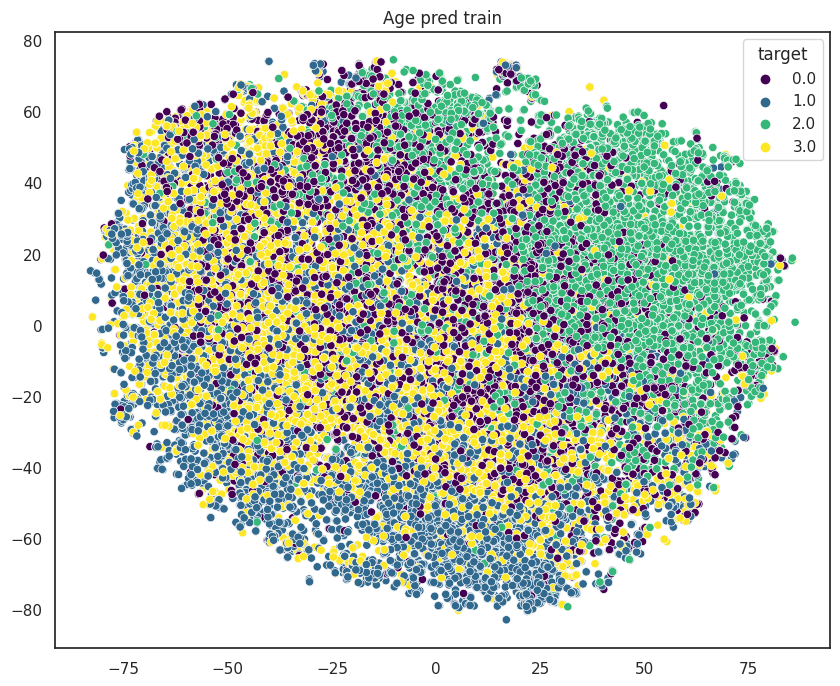

In [20]:
from sklearn.manifold import TSNE

X = merged_data.drop(columns=['target', 'client_id'])
y = merged_data['target']

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis')
plt.title('Age pred train')
plt.show()

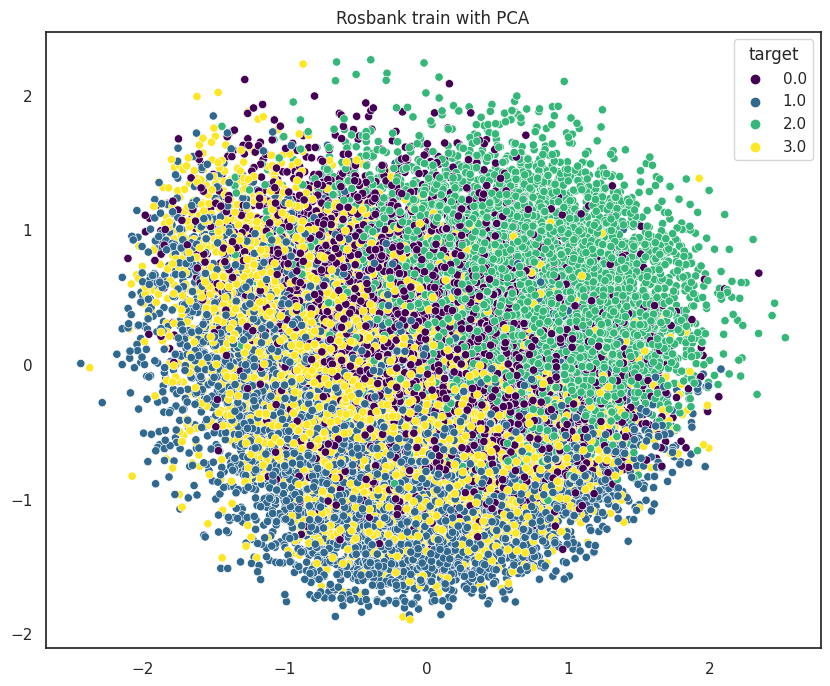

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X = merged_data.drop(columns=['target', 'client_id'])
y = merged_data['target']

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title('Rosbank train with PCA')
plt.show()

In [25]:
del umap

/home/jovyan/.local/share/virtualenvs/ptls-experiments-Xgdpvmv-/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


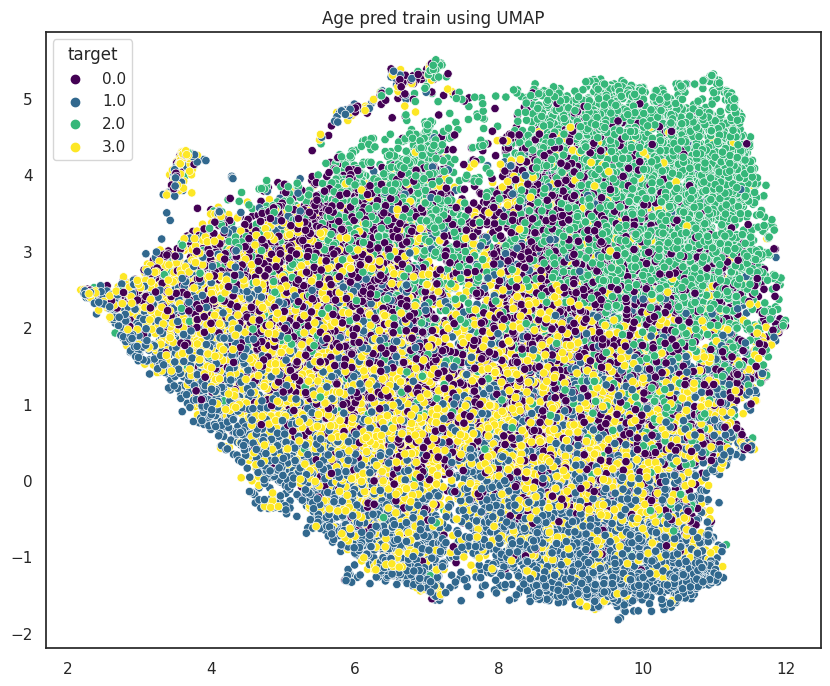

In [17]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# Подготовьте свои данные
X = merged_data.drop(columns=['target', 'client_id'])
y = merged_data['target']

# Используйте UMAP для уменьшения размерности
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

# Визуализируйте результаты
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis')
plt.title('Age pred train using UMAP')
plt.show()
